Стадия I

Программа принимает на вход скорости и координаты космических объектов и рассчитывает их положение и
скорость в зависимости от времени методом численного решения уравнений Ньютона. Обоснован выбор
разностной схемы и шага интеграции, требуемая точность - 10 cм за неделю. Расчёт на GPU
Все расчёты в системе единиц СИ. Чтобы так не получилось.



В коде есть интерфейс для простого добавления новых сил, действующих на объекты. Силы могут зависеть от
времени, скорости и координат объекта, параметров объекта. В нём реализована элементарная модель
гравитации, где Земля - шар.

Есть визуализатор, для заданных id объектов и интервалу времени, рисующий их траекторию картинкой. В отчёте
есть траектории 10 случайных объектов на протяжении суток.

# Генератор входных данных

Есть код, генерирующий случайные начальные условия для 21000 объектов. Круговые орбиты, высота
распределена по Гауссу, средняя 800 км, дисперсия 200 км, плоскости - равномерно. Размеры объектов от 1 см до
10 м, распределены с pdf = 1/object_size

Формат данных для каждого обьекта

- ```object_id```
- ```position```
- ```size```
- ```motion_vector```

Допустим мы напишем генератор на python и данные по обьектам будем просто писать в csv файл.

https://upload.wikimedia.org/wikipedia/commons/2/24/Orbital_state_vectors.png

https://upload.wikimedia.org/wikipedia/commons/c/c0/Spherical_with_grid.svg

In [48]:
import csv
import numpy as np


def spherical_to_decart(radius, theta, phi):
    x = radius * np.sin(theta) * np.cos(phi)
    y = radius * np.sin(theta) * np.sin(phi)
    z = radius * np.cos(theta)
    return x, y, z


def decart_to_spherical(x, y, z):
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z/r)
    phi = np.arctan(y / x)
    return r, theta, phi


def draw_random_number_from_pdf(pdf, interval, pdfmax=1, integers=False, max_iterations=10000):
    """
    Draws a random number from given probability density function.

    Parameters
    ----------
        pdf       -- the function pointer to a probability density function of form P = pdf(x)
        interval  -- the resulting random number is restricted to this interval
        pdfmax    -- the maximum of the probability density function
        integers  -- boolean, indicating if the result is desired as integer
        max_iterations -- maximum number of 'tries' to find a combination of random numbers (rand_x, rand_y) located below the function value calc_y = pdf(rand_x).

    returns a single random number according the pdf distribution.
    """
    for i in range(max_iterations):
        if integers == True:
            rand_x = np.random.randint(interval[0], interval[1])
        else:
            # (b - a) * random_sample() + a
            rand_x = (interval[1] - interval[0]) * \
                np.random.random(1) + interval[0]

        rand_y = pdfmax * np.random.random(1)
        calc_y = pdf(rand_x)

        if (rand_y <= calc_y):
            return rand_x

    raise Exception("Could not find a matching random number within pdf in " +
                    max_iterations + " iterations.")


def generate_object_states(object_count=100,
                           orbit_type='circle',
                           orbit_altitude_mean=800000,
                           orbit_altitude_var=200000,
                           object_min_size=0.1,
                           object_max_size=10.0) -> 'list of object parameters':
   
  

    """Generate object position"""
    mu, sigma, size = orbit_altitude_mean, orbit_altitude_var, object_count
    altitudes = np.random.normal(mu, sigma, size)

    thetas_0 = np.random.uniform(0, 2*np.pi, size=object_count)
    phis_0 = np.random.uniform(0, 2*np.pi, size=object_count)
    
    
    """Generate speed vector"""

    """Generate object sizes"""
    sizes = [draw_random_number_from_pdf(lambda x: 1 / x, [object_min_size, object_max_size])[0]
             for _ in range(object_count)]

    object_list = []
    for object_idx, altitude, theta_0, phi_0, size in zip(
            range(object_count), altitudes, thetas_0, phis_0, sizes):
        x_0, y_0, z_0 = spherical_to_decart(altitude, theta_0, phi_0)
        
        
        eps = 0.000000001*np.pi
        theta_1 = np.random.uniform(theta_0 - eps, theta_0 + eps, size=object_count)
        phi_1 = np.random.uniform(phi_0 - eps, phi_0 + eps, size=object_count)
        x_1, y_1, z_1 = spherical_to_decart(altitude, theta_1, phi_1)
        vx_0 = x_1 - x_0
        vy_0 = y_1 - y_0
        vz_0 = z_1 - z_0
        
        object_list.append({'time': 0.0,
                            'object_id': object_idx,
                            'x': x_0,
                            'y': y_0,
                            'z': z_0,
                            'vx' : vx_0,
                            'vy' : vy_0,
                            'vz' : vz_0,
                            'size': size})

    return object_list


def generates_objects_in_file(filename,
                              object_count=100,
                              orbit_type='circle',
                              orbit_altitude_mean=800000,
                              orbit_altitude_var=200000,
                              object_min_size=0.1,
                              object_max_size=10.0):
    object_list = generate_object_states(object_count, orbit_type, orbit_altitude_mean,
                                            orbit_altitude_var, object_min_size, object_max_size)
    time = 0
    with open(filename, 'w', newline='') as csvfile:
        spamwriter = csv.writer(csvfile, delimiter=' ',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)
        for space_object in object_list:
            spamwriter.writerow([time,
                                 space_object['object_id'],
                                 space_object['x'],
                                 space_object['y'],
                                 space_object['z'],
                                 space_object['vx'],
                                 space_object['vy'],
                                 space_object['vz'],
                                 space_object['size']])
    return -1

In [49]:
generates_objects_in_file('objects.csv', object_count=1)

-1

In [50]:
!head objects.csv

In [51]:
import numpy as np

def randint_with_dist(pdf):
    choices = []
    for index, value in enumerate(pdf):
        choices.extend(index for _ in range(value))
    return random.choice(choices)

# Визуализация

In [54]:
import csv
object_list = []

with open('objects.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',', quoting=csv.QUOTE_NONNUMERIC)
    line_count = 0
    for row in csv_reader:
        print(row[0])
    print(f'Processed {line_count} lines.')

ValueError: could not convert string to float: '0 0 608196.3260526877 -323540.31489077414 -909185.7140271649 [-0.00227395] [0.00172221] [-0.00213401] 8.605060691503237'

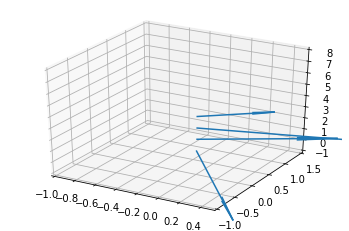

In [18]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import random
%matplotlib notebook

fig = pyplot.figure()
ax = Axes3D(fig)

sequence_containing_x_vals = list(range(0, 100))
sequence_containing_y_vals = list(range(0, 100))
sequence_containing_z_vals = list(range(0, 100))

random.shuffle(sequence_containing_x_vals)
random.shuffle(sequence_containing_y_vals)
random.shuffle(sequence_containing_z_vals)

ax.scatter(sequence_containing_x_vals, sequence_containing_y_vals, sequence_containing_z_vals)
pyplot.show()

<IPython.core.display.Javascript object>


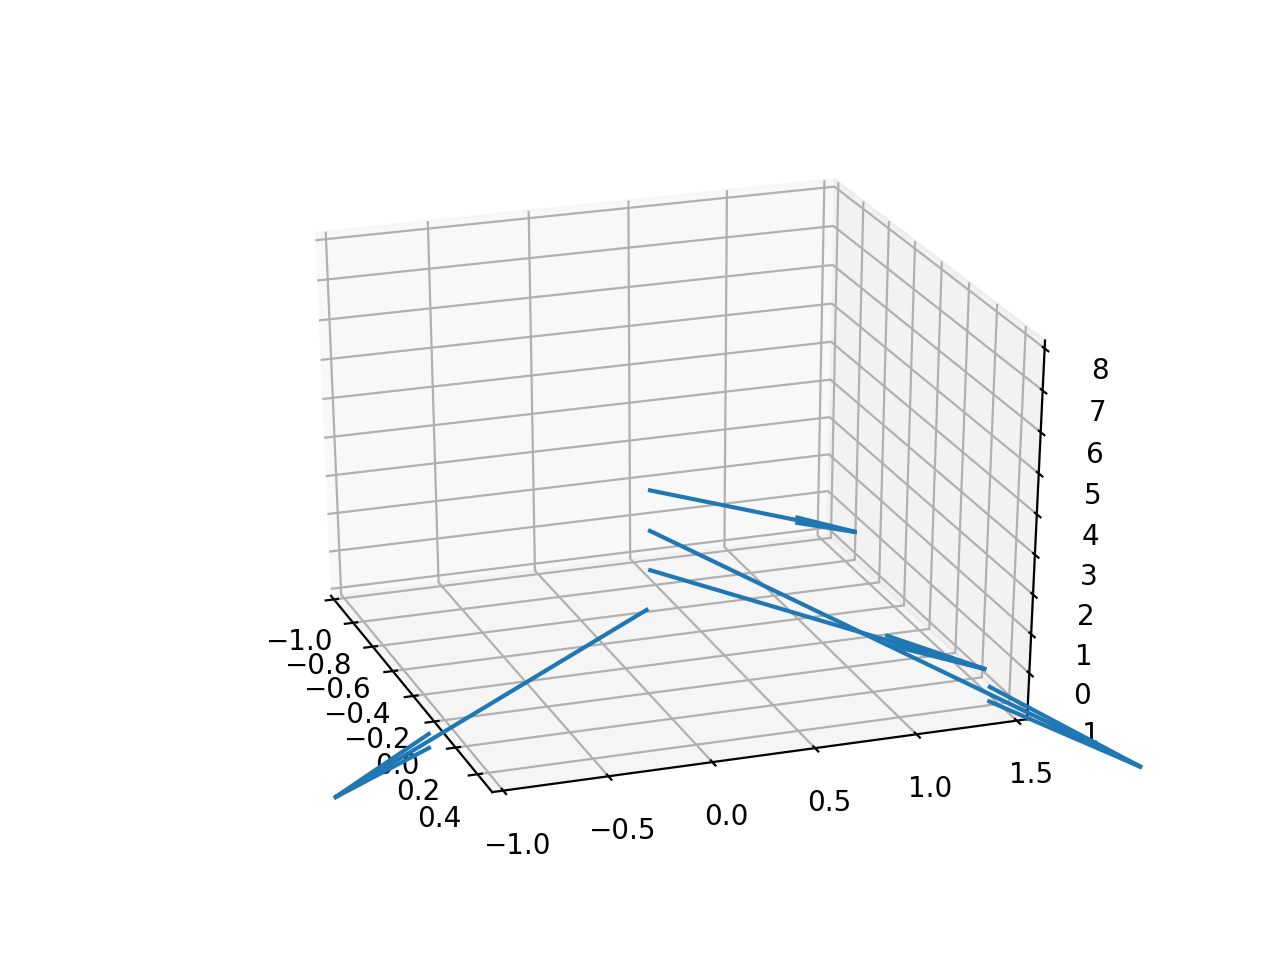

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
%matplotlib notebook

soa = np.array([[0, 0, 1, 1, -2, 0], [0, 0, 2, 1, 1, 0],
                [0, 0, 3, 2, 1, 0], [0, 0, 4, 0.5, 0.7, 0]])

X, Y, Z, U, V, W = zip(*soa)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(X, Y, Z, U, V, W)
ax.set_xlim([-1, 0.5])
ax.set_ylim([-1, 1.5])
ax.set_zlim([-1, 8])
plt.show()